In [261]:
# import 구문 정렬
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from scipy.io import arff
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import (LeakyReLU, Activation, Conv1D, MaxPooling1D, Flatten, Dense, 
                                    BatchNormalization, ReLU, GlobalAveragePooling1D, Dropout, 
                                    GlobalMaxPooling1D)
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import auc, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Plotting settings
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # minus 표시


In [262]:
# 설비에서 얻어진 원본 데이터 파일은 총 25개
# 25개 파일에 대한 요약 파일을 데이터프레임 형태로 변환
summary_df = pd.read_csv('./cnc_data/train.csv')
summary_df

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,aluminum,6,4.0,unworn,yes,yes
1,2,aluminum,20,4.0,unworn,yes,yes
2,3,aluminum,6,3.0,unworn,yes,yes
3,4,aluminum,6,2.5,unworn,no,NaN
4,5,aluminum,20,3.0,unworn,no,NaN
5,6,aluminum,6,4.0,worn,yes,no
6,7,aluminum,20,4.0,worn,no,NaN
7,8,aluminum,20,4.0,worn,yes,no
8,9,aluminum,15,4.0,worn,yes,no
9,10,aluminum,12,4.0,worn,yes,no


- 공정 미완료 항목은 visual 검사가 진행되지 않아 결과 항목(passed_visual_inspection)이 NaN 처리 되어 있음

In [263]:
# 설비에서 얻어진 원본 데이터 파일 25개의 제목을 리스트로 저장
# - 25개 파일을 하나로 합칠때 사용
# - 요약파일에 있는 라벨을 원본에 추가할때 사용

import glob

all_files = glob.glob('./cnc_data/*.csv')
all_files = all_files[:-1] # train.csv 파일은 제외
all_files.sort() # 파일 이름순으로 정렬
all_files

['./cnc_data/experiment_01.csv',
 './cnc_data/experiment_02.csv',
 './cnc_data/experiment_03.csv',
 './cnc_data/experiment_04.csv',
 './cnc_data/experiment_05.csv',
 './cnc_data/experiment_06.csv',
 './cnc_data/experiment_07.csv',
 './cnc_data/experiment_08.csv',
 './cnc_data/experiment_09.csv',
 './cnc_data/experiment_10.csv',
 './cnc_data/experiment_11.csv',
 './cnc_data/experiment_12.csv',
 './cnc_data/experiment_13.csv',
 './cnc_data/experiment_14.csv',
 './cnc_data/experiment_15.csv',
 './cnc_data/experiment_16.csv',
 './cnc_data/experiment_17.csv',
 './cnc_data/experiment_18.csv',
 './cnc_data/experiment_19.csv',
 './cnc_data/experiment_20.csv',
 './cnc_data/experiment_21.csv',
 './cnc_data/experiment_22.csv',
 './cnc_data/experiment_23.csv',
 './cnc_data/experiment_24.csv',
 './cnc_data/experiment_25.csv']

In [264]:
# 25개 원본 파일을 데이터프레임 형태로 변환 후 리스트에 저장
df_list = []
for i, file in enumerate(all_files):
    df_list.append(pd.read_csv(file))

# 25개 각 파일의 길이(데이터 개수)를 리스트에 저장
df_list_len = []
for i in range(len(df_list)):
    df_list_len.append(df_list[i].shape[0])
    
# 결과 요약 df에 각 파일의 길이(데이터 개수) 추가
summary_df['df_len'] = df_list_len

# 공정 미완료 항목('machining_finalized'=='no')은 'passed_visual_inspection'=='no' 인것으로 할당
summary_df.passed_visual_inspection.fillna('no', inplace=True)
summary_df

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection,df_len
0,1,aluminum,6,4.0,unworn,yes,yes,1055
1,2,aluminum,20,4.0,unworn,yes,yes,1668
2,3,aluminum,6,3.0,unworn,yes,yes,1521
3,4,aluminum,6,2.5,unworn,no,no,532
4,5,aluminum,20,3.0,unworn,no,no,462
5,6,aluminum,6,4.0,worn,yes,no,1296
6,7,aluminum,20,4.0,worn,no,no,565
7,8,aluminum,20,4.0,worn,yes,no,605
8,9,aluminum,15,4.0,worn,yes,no,740
9,10,aluminum,12,4.0,worn,yes,no,1301


## EDA

In [265]:
# 공정 완료, 미완료 구분 -> visual 검사 결과 클래스별 빈도수
target_rate_df = summary_df.groupby(['machining_finalized', 'passed_visual_inspection']).sum().reset_index()
target_rate_df


/var/folders/vf/j0dck67d0j1dpgnk9c8mynz00000gn/T/ipykernel_66127/3975093127.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  target_rate_df = summary_df.groupby(['machining_finalized', 'passed_visual_inspection']).sum().reset_index()


,machining_finalized,passed_visual_inspection,No,feedrate,clamp_pressure,df_len
0,no,no,75,81,20.5,3228
1,yes,no,73,71,24.0,6175
2,yes,yes,177,85,41.5,22645


공정 미완료 fail : 3228 (10.07%)
공정 완료 fail : 6175(19.27%)
공정 완료 pass : 22645(70.66%)


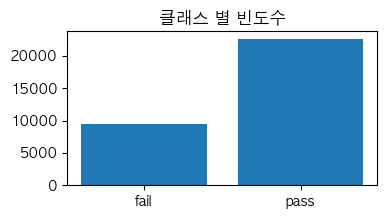

In [266]:
# 공정 완료여부, visual 검사 결과에 따라 3가지로 구분하여 비율 확인
not_finalized = target_rate_df.loc[0].df_len
finalized_fail = target_rate_df.loc[1].df_len
finalized_pass = target_rate_df.loc[2].df_len
sum_fail_pass = not_finalized + finalized_fail + finalized_pass
print(f'공정 미완료 fail : {not_finalized} ({round(not_finalized/sum_fail_pass*100,2)}%)')
print(f'공정 완료 fail : {finalized_fail}({round(finalized_fail/sum_fail_pass*100,2)}%)')
print(f'공정 완료 pass : {finalized_pass}({round(finalized_pass/sum_fail_pass*100,2)}%)')
plt.figure(figsize=(4,2))
plt.bar(['fail', 'pass'], [not_finalized + finalized_fail, finalized_pass])
plt.title('클래스 별 빈도수')
plt.show()

- pass, fail 클래스의 비중이 약 7:3
-> 학습하는데 문제는 없음

## 데이터 전처리

In [267]:
# 결과요약 feature를 원본파일에 합치기
df_list_add = []
for i in range(len(df_list)): # 파일 개수만큼 반복
    # 결과 요약의 i번째 줄을 i번째 원본파일의 길이만큼 복사
    add_df = pd.DataFrame([summary_df.iloc[i,:]] * len(df_list[i])).reset_index(drop=True)
    # i번째 원본파일의 열에 붙이기 -> 확장된 데이터프레임을 리스트에 저장
    df_list_add.append(pd.concat([df_list[i], add_df], axis=1))
    print(df_list_add[i].shape)

(1055, 56)
(1668, 56)
(1521, 56)
(532, 56)
(462, 56)
(1296, 56)
(565, 56)
(605, 56)
(740, 56)
(1301, 56)
(2314, 56)
(2276, 56)
(2233, 56)
(2332, 56)
(1381, 56)
(602, 56)
(2150, 56)
(2253, 56)
(565, 56)
(605, 56)
(1668, 56)
(565, 56)
(462, 56)
(2332, 56)
(565, 56)


- 25개의 데이터 프레임의 열 개수는 모두 56개

In [268]:
# 확장된 25개 데이터프레임을 하나로 합치기
concat_df = pd.DataFrame()
for i in range(len(df_list)):
    concat_df = pd.concat([concat_df, df_list_add[i]])

print(concat_df.shape)

(32048, 56)


In [269]:
# 25개의 데이터프레임이 각각의 인덱스를 갖기 때문에 합친 후 reset_index()
concat_df.reset_index(drop=True, inplace=True)
concat_df

,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,M_CURRENT_FEEDRATE,Machining_Process,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection,df_len
0,202.0,4.0000,4.00,202.0,4.0,4.000000,0.180,0.0207,329,2.77,...,50,Starting,1,aluminum,6,4.0,unworn,yes,yes,1055
1,202.0,-6.8000,-346.00,202.0,-9.6,-354.000000,-10.900,0.1860,328,23.30,...,50,Prep,1,aluminum,6,4.0,unworn,yes,yes,1055
2,200.0,-13.8000,-2.25,200.0,-13.9,3.999905,-8.590,0.1400,328,30.60,...,50,Prep,1,aluminum,6,4.0,unworn,yes,yes,1055
3,198.0,-14.0000,4.00,198.0,-13.9,3.999905,-6.110,0.1300,327,30.30,...,50,Prep,1,aluminum,6,4.0,unworn,yes,yes,1055
4,197.0,-13.9000,-14.80,196.0,-13.9,4.000095,-5.700,0.1140,328,30.50,...,50,Prep,1,aluminum,6,4.0,unworn,yes,yes,1055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32043,179.0,3.5625,8.15,179.0,3.5,5.000000,-0.941,0.0215,328,1.79,...,20,End,25,aluminum,6,2.5,worn,yes,yes,565
32044,178.5,3.5350,30.00,178.5,3.5,5.000000,-0.780,0.0202,328,1.07,...,20,End,25,aluminum,6,2.5,worn,yes,yes,565
32045,178.5,3.5475,17.50,178.5,3.5,5.000000,0.501,0.0190,328,0.99,...,20,End,25,aluminum,6,2.5,worn,yes,yes,565
32046,178.5,3.4475,11.25,178.5,3.5,5.000000,-0.298,0.0193,328,1.37,...,20,End,25,aluminum,6,2.5,worn,yes,yes,565


In [270]:
# 중복 단어 변경
concat_df.Machining_Process.replace({'end':'End'}, inplace=True)
concat_df.Machining_Process.unique()


array(['Starting', 'Prep', 'Layer 1 Up', 'Layer 1 Down', 'Repositioning',
       'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down', 'End'],
      dtype=object)

In [271]:
# 불필요한 feature 제거 (모든 값이 같거나 의미 없는 데이터 제거)
concat_df = concat_df.drop(['Z_CurrentFeedback', 'Z_DCBusVoltage', 'Z_OutputCurrent',
                            'Z_OutputVoltage', 'No', 'material', 'df_len'], axis=1)

# 이진 데이터 값을 1과 0으로 변환
concat_df.passed_visual_inspection.replace({'yes':1, 'no':0}, inplace=True)
concat_df.tool_condition.replace({'worn':1, 'unworn':0}, inplace=True)
concat_df.machining_finalized.replace({'yes':1, 'no':0}, inplace=True)

# 라벨 열 이름 바꾸기
concat_df.rename(columns={'passed_visual_inspection' : 'target'}, inplace=True)


# 원핫인코딩 : 'M_CURRENT_PROGRAM_NUMBER', 'Machining_Process'
# 원핫인코딩 후 2개 열 삭제

df = concat_df.copy()

dum_program_num = pd.get_dummies(df.M_CURRENT_PROGRAM_NUMBER, prefix='p_num')
dum_process_num = pd.get_dummies(df.Machining_Process, prefix='process')
df = pd.concat([df, dum_process_num, dum_program_num], axis=1)
df.drop(['M_CURRENT_PROGRAM_NUMBER', 'Machining_Process'], axis=1, inplace=True)
print(df.shape)

(32048, 60)


- 모든 데이터 전처리 완료 후 데이터프레임의 크기 : 32048개의 행, 61개의 열

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_ActualPosition       32048 non-null  float64
 1   X_ActualVelocity       32048 non-null  float64
 2   X_ActualAcceleration   32048 non-null  float64
 3   X_SetPosition          32048 non-null  float64
 4   X_SetVelocity          32048 non-null  float64
 5   X_SetAcceleration      32048 non-null  float64
 6   X_CurrentFeedback      32048 non-null  float64
 7   X_DCBusVoltage         32048 non-null  float64
 8   X_OutputCurrent        32048 non-null  int64  
 9   X_OutputVoltage        32048 non-null  float64
 10  X_OutputPower          32048 non-null  float64
 11  Y_ActualPosition       32048 non-null  float64
 12  Y_ActualVelocity       32048 non-null  float64
 13  Y_ActualAcceleration   32048 non-null  float64
 14  Y_SetPosition          32048 non-null  float64
 15  Y_

## EDA2

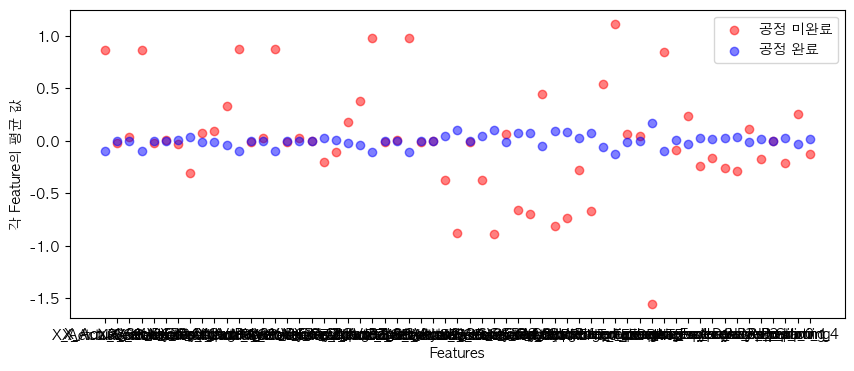

In [273]:
## 공정 미완료 데이터 3228개 (10.1%)를 학습에 포함 시키는게 맞는지 확인
# - 클래스를 결정하는 공정 조건을 찾는게 목적이기 때문
# - 단순히 공정이 완료 되지 않아서 fail 클래스로 구분되었다면 노이즈 데이터가 될 수 있음

# feature별로 분포가 크기때문에 스케일링 작업
from sklearn.preprocessing import StandardScaler

df_target_origin = df.target # 스케일링 하기 전에 라벨을 저장해둠
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# 공정 완료, 미완료 클래스를 그룹화하여 feature들의 평균값 출력
df_mean = df_scaled.groupby('machining_finalized').mean().reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.scatter(df_mean.columns, df_mean.values[0], alpha=0.5, color='red', label='공정 미완료')
plt.scatter(df_mean.columns, df_mean.values[1], alpha=0.5, color='blue', label='공정 완료')
plt.xlabel('Features')
plt.ylabel('각 Feature의 평균 값')
plt.legend()
plt.show()

- 공정 미완료 클래스와 완료 클래스의 feature 값에 유의미한 차이가 있음.
- 단순히 시간적으로 공정이 미완료 된 것이 아니라, 조건의 차이로 인해 문제가 발생되어 공정이 완료되지 않은 것으로 보임
- 따라서, 미완료 항목을 포함하여 학습 시키는 것이 맞음. (fail 클래스의 feature 특징을 가지고 있음)

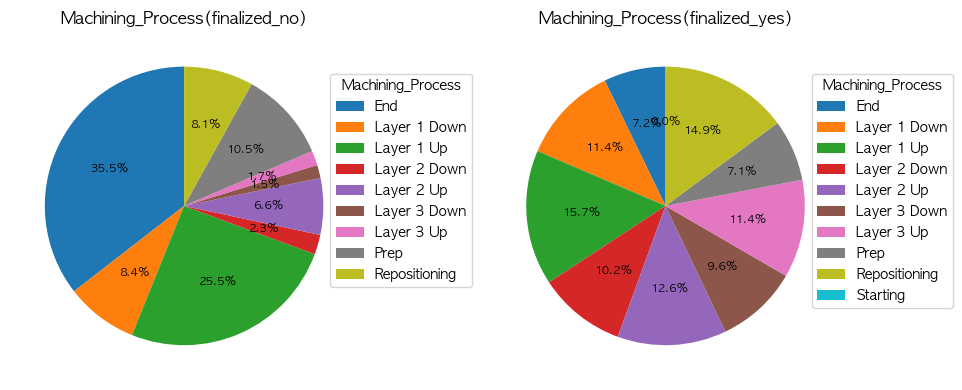

In [274]:
# 공정 완료, 미완료 클래스의 현재 진행 공정 분포 확인
# -> df는 이미 원핫인코딩을 했기 때문에 concat_df 사용

finalized_y = concat_df.loc[concat_df.machining_finalized==1].Machining_Process.value_counts().sort_index()
finalized_n = concat_df.loc[concat_df.machining_finalized==0].Machining_Process.value_counts().sort_index()

fig, axs = plt.subplots(1,2, figsize=(10,4))

# 공정 미완료 클래스 그래프
axs[0].pie(finalized_n.values, labels=None, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
axs[0].legend(finalized_n.index, title="Machining_Process", loc='best', bbox_to_anchor=(0.9, 0, 0.1, 0.9))
axs[0].set_title('Machining_Process(finalized_no)')

# 공정 완료 클래스 그래프
axs[1].pie(finalized_y.values, labels=None, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
axs[1].legend(finalized_y.index, title="Machining_Process", loc="best", bbox_to_anchor=(0.9, 0, 0.1, 0.9))
axs[1].set_title('Machining_Process(finalized_yes)')

fig.tight_layout()
plt.show()

- 공정 완료 데이터는 현재 공정의 빈도가 균일함
- 공정 미완료 데이터는 현재 공정의 빈도가 'End'와 'Layer1Up'에 쏠리는 경향
- 학습 시키는데 영향 없음.

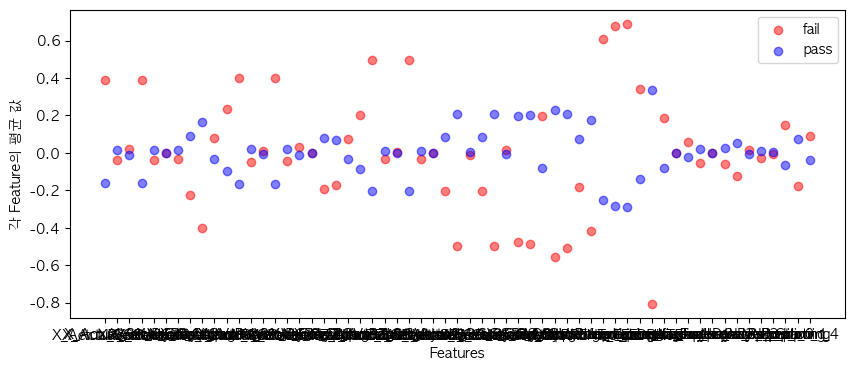

In [275]:
# target 클래스별 feature 분포 확인

df_target_mean = df_scaled.groupby('target').mean().reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.scatter(df_target_mean.columns, df_target_mean.values[0], alpha=0.5, color='red', label='fail')
plt.scatter(df_target_mean.columns, df_target_mean.values[1], alpha=0.5, color='blue', label='pass')
plt.xlabel('Features')
plt.ylabel('각 Feature의 평균 값')
plt.legend()
plt.show()

In [276]:
# target 클래스별(pass, fail) 평균 값 차이가 큰 feature 확인

x1 = pd.Series(abs(df_target_mean.values[1] - df_target_mean.values[0]))
x2 = pd.Series(df_target_mean.columns)
x1_x2 = pd.concat([x1, x2], axis=1)

# 상위 10개 feature
x1_x2.sort_values(by=0, ascending=False).head(10)


,0,1
45,1.140655,machining_finalized
43,0.977073,clamp_pressure
42,0.961544,feedrate
41,0.862805,M_CURRENT_FEEDRATE
37,0.786793,S_OutputVoltage
38,0.717714,S_OutputPower
32,0.704193,S_SetVelocity
29,0.700479,S_ActualVelocity
25,0.700462,Z_SetPosition
22,0.700419,Z_ActualPosition


- top1,2,3 feature가 결과 요약 파일에 있는 feature
- 결과 요약파일의 정보가 라벨 클래스에 영향을 크게 주는 것으로 보임
- 결과 요약파일은 설비에서 자동으로 얻어지는 데이터가 아니므로 포함/미포함 하여 학습 시켜볼 필요 있음

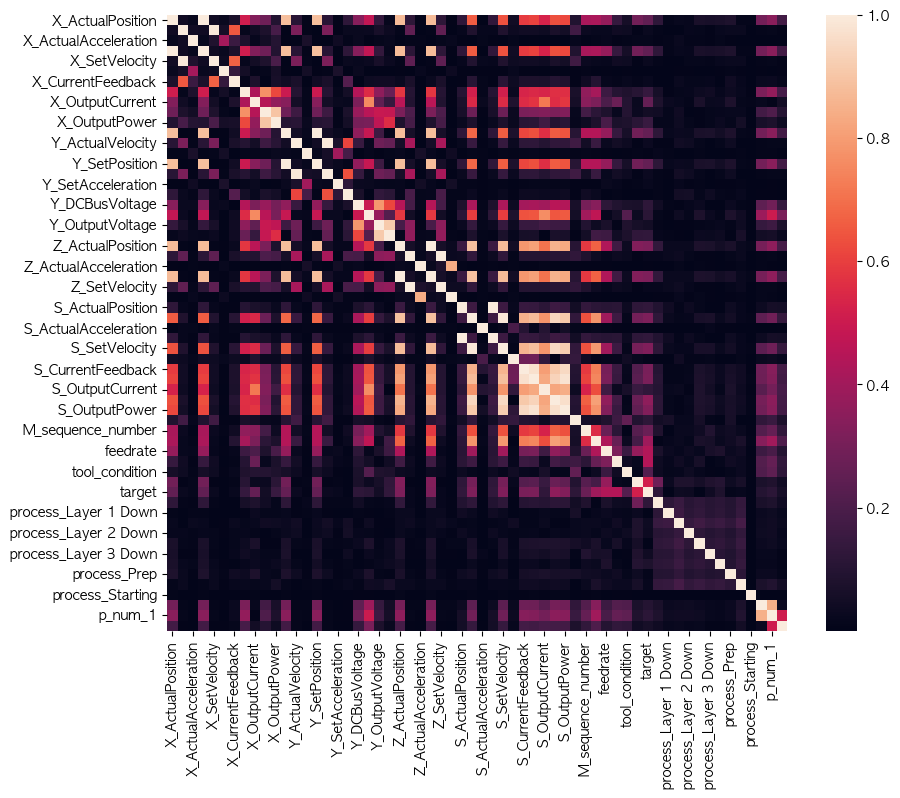

[target과 상관계수 높은 feature top10]
machining_finalized    0.519365
clamp_pressure         0.444883
feedrate               0.437812
M_CURRENT_FEEDRATE     0.392854
S_OutputVoltage        0.358244
S_OutputPower          0.326791
S_SetVelocity          0.320635
S_ActualVelocity       0.318943
Z_SetPosition          0.318936
Z_ActualPosition       0.318916
Name: target, dtype: float64


In [277]:
# 상관계수 히트맵
plt.figure(figsize=(10,8))
df_corr = abs(df.corr())
sns.heatmap(df_corr)
plt.show()

# target과 상관계수 높은 feature top10
print('[target과 상관계수 높은 feature top10]')
print(df_corr.target.sort_values(ascending=False).head(11).drop('target'))

- target과 상관계수 높은 feature top10 항목과
- target 클래스 별 평균값 차이가 큰 feature top10 은 일치함
- -> 클래스별 평균 값 차이가 큰 feature가 클래스 결정에 영향을 준다.

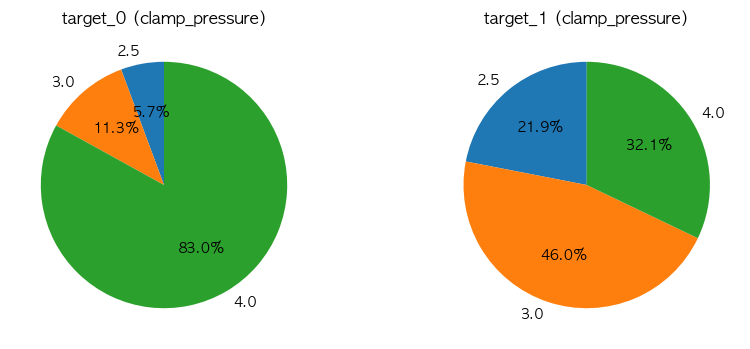

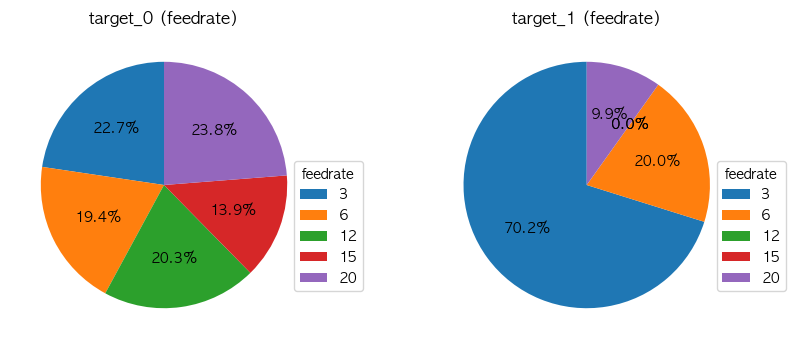

In [278]:
## 결과 요약 파일의 feature 값이 target 클래스별로 어떻게 차이가 있는지 시각화

# target 과 상관계수 top1 피쳐인 clamp_pressure의 클래스별 분포
df.clamp_pressure.value_counts()
df.groupby(['target', 'clamp_pressure']).count()
t_0_pressure = df.loc[df.target==0].clamp_pressure.value_counts().sort_index()
t_1_pressure = df.loc[df.target==1].clamp_pressure.value_counts().sort_index()
t_0_pressure

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].pie(t_0_pressure.values, labels=t_0_pressure.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('target_0 (clamp_pressure)')
axs[1].pie(t_1_pressure.values, labels=t_1_pressure.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('target_1 (clamp_pressure)')
plt.show()

# target 과 상관계수 top2 피쳐인 feedrate의 클래스별 분포
df.feedrate.value_counts()
df.groupby(['target', 'feedrate']).count()
t_0_feedrate = df.loc[df.target==0].feedrate.value_counts().sort_index()
t_1_feedrate = df.loc[df.target==1].feedrate.value_counts().sort_index()

# index를 맞추기 위해 concat
concat_feed = pd.concat([t_0_feedrate, t_1_feedrate], axis=1)
concat_feed.fillna(0, inplace=True)

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].pie(concat_feed.iloc[:,0].values, labels=None, autopct='%1.1f%%', startangle=90)
axs[0].set_title('target_0 (feedrate)')
axs[0].legend(concat_feed.iloc[:,0].index, title="feedrate", loc='best', bbox_to_anchor=(0.9, 0, 0.1, 0.6))

axs[1].pie(concat_feed.iloc[:,1].values, labels=None, autopct='%1.1f%%', startangle=90)
axs[1].set_title('target_1 (feedrate)')
axs[1].legend(concat_feed.iloc[:,1].index, title="feedrate", loc='best', bbox_to_anchor=(0.9, 0, 0.1, 0.6))
plt.show()


## 학습, 평가

In [279]:
# train, test 데이터셋 나누기 (target 비율을 고려해서)
train_df, test_df = train_test_split(df, test_size = 0.3, stratify=df['target'])
print('[데이터셋 shape]')
print(f'df : {df.shape}')
print(f'train_df : {train_df.shape} (70%)')
print(f'test_df : {test_df.shape} (30%)\n')

# train, test 데이터셋 인덱스 초기화 (데이터셋 합치기 전 각각의 인덱스를 가지고 있었음)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# train_df, test_df target 빈도 확인
print(f'[train_df target 빈도] \n{train_df.target.value_counts()}\n')
print(f'[test_df target 빈도] \n{test_df.target.value_counts()}\n')

# 라벨 열 나누기
x_train = train_df.drop('target', axis=1)
y_train = train_df.target
x_test = test_df.drop('target', axis=1)
y_test = test_df.target
print('[데이터셋 shape]')
print(f'x_train shape : {x_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'x_test shape : {x_test.shape}')
print(f'y_test shape : {y_test.shape}')


[데이터셋 shape]
df : (32048, 60)
train_df : (22433, 60) (70%)
test_df : (9615, 60) (30%)

[train_df target 빈도] 
1    15851
0     6582
Name: target, dtype: int64

[test_df target 빈도] 
1    6794
0    2821
Name: target, dtype: int64

[데이터셋 shape]
x_train shape : (22433, 59)
y_train shape : (22433,)
x_test shape : (9615, 59)
y_test shape : (9615,)


In [280]:
# ##  ML 모델별로 학습 및 예측 결과

# # 학습 및 예측 모델 4가지 리스트 (XGBoost, LightGBM, CatBoost, RandomForest)
# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0),
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)

# # 캔버스 4개 만들기 (혼동행렬 / ROC Curve / Feat.Imp. 상위 10항목 / Feat.Imp. 전체 분포)
# fig, axs = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))
# fig2, axs2 = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))

# # 캔버스 4개의 title
# fig.suptitle('[각 모델의 혼동 행렬]', fontsize=14)
# fig2.suptitle('[각 모델의 ROC Curve]', fontsize=14)

# # 4개 ML 모델 학습 후 정확도, 혼동행렬, ROC, Feature Importance 출력하기
# for i in range(len(model)): # 모델 리스트 크기만큼 반복
#     model[i].fit(x_train, y_train) # 모델 한개씩 불러와서 학습
#     y_pred = model[i].predict(x_test) # 각 모델 예측값
#     probs = model[i].predict_proba(x_test)[:, 1] # 각 모델 클래스 1의 예측 확률
    
#     # 평가지표 계산
#     accuracy = accuracy_score(y_test, y_pred) # 정확도
#     precision = precision_score(y_test, y_pred) # 정밀도: 양성이라고 예측한것중 실제 양성의 비율
#     recall = recall_score(y_test, y_pred) # 재현율(민감도): 실제 양성 중 양성으로 예측된 비율
#     f1 = f1_score(y_test, y_pred) # f1: 2 * (정밀도*재현율)/(정밀도+재현율)
#     auc_score = roc_auc_score(y_test, probs)  # AUC 계산 (ROC 곡선 아래의 면적)
    
#     # 평가지표 출력
#     print(f"{model_list[i]}:")
#     print(f" - Accuracy: {round(accuracy*100,2)}%")
#     print(f" - Precision: {round(precision*100,2)}%")
#     print(f" - Recall: {round(recall*100,2)}%")
#     print(f" - F1 Score: {round(f1*100,2)}%")
#     print(f" - AUC: {round(auc_score*100,2)}%")

#     # 각 모델의 혼동 행렬을 히트맵으로 그리기
#     conf_mat = confusion_matrix(y_test, y_pred) # 혼동 행렬 만들기 (2,2)
#     sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axs[i])
#     axs[i].set_title(model_list[i])
#     axs[i].set_ylabel('Actual')
#     axs[i].set_xlabel('Predicted')

#     # 각 모델의 ROC Curve 그리기
#     fpr, tpr, thresholds = roc_curve(y_test, probs) # fpr, tp, thresholds 값 할당
#     axs2[i].plot(fpr, tpr, color='red', label=f'AUC = {auc_score:.2f}') # ROC Curve 그리기
#     axs2[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     axs2[i].set_title(model_list[i])
#     axs2[i].set_xlabel('FPR')
#     axs2[i].set_ylabel('TPR')
#     axs2[i].legend(loc="lower right")
#     print("-----------------------------------------------------")
        
# fig.tight_layout(), fig2.tight_layout()
# plt.show()

- CatBoost, RandomForest 모델에서 테스트데이터셋 예측 정확도 100% 기록
- 결과 요약 파일의 feature 는 삭제하고 학습 할 필요 있음. (설비에서 자동으로 저장되는 데이터만 사용)

In [281]:
###### 결과 테이블에 있는 feature 삭제하고 학습 시켜보기
print(f'결과 테이블 feature 삭제 전 df.shape : {df.shape}')
df = df.drop(['feedrate', 'clamp_pressure', 'tool_condition', 'machining_finalized'], axis=1)
print(f'결과 테이블 feature 삭제 후 df.shape : {df.shape}\n')

# train, test 데이터셋 나누기 (target 비율을 고려해서)
train_df, test_df = train_test_split(df, test_size = 0.3, stratify=df['target'])
print('[데이터셋 shape]')
print(f'df : {df.shape}')
print(f'train_df : {train_df.shape} (70%)')
print(f'test_df : {test_df.shape} (30%)\n')

# train, test 데이터셋 인덱스 초기화 (데이터셋 합치기 전 각각의 인덱스를 가지고 있었음)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# train_df, test_df target 빈도 확인
print(f'[train_df target 빈도] \n{train_df.target.value_counts()}\n')
print(f'[test_df target 빈도] \n{test_df.target.value_counts()}\n')

# 라벨 열 나누기
x_train = train_df.drop('target', axis=1)
y_train = train_df.target
x_test = test_df.drop('target', axis=1)
y_test = test_df.target
print('[데이터셋 shape]')
print(f'x_train shape : {x_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'x_test shape : {x_test.shape}')
print(f'y_test shape : {y_test.shape}')

결과 테이블 feature 삭제 전 df.shape : (32048, 60)
결과 테이블 feature 삭제 후 df.shape : (32048, 56)

[데이터셋 shape]
df : (32048, 56)
train_df : (22433, 56) (70%)
test_df : (9615, 56) (30%)

[train_df target 빈도] 
1    15851
0     6582
Name: target, dtype: int64

[test_df target 빈도] 
1    6794
0    2821
Name: target, dtype: int64

[데이터셋 shape]
x_train shape : (22433, 55)
y_train shape : (22433,)
x_test shape : (9615, 55)
y_test shape : (9615,)


XGBClassifier:
 - Accuracy: 96.39%
 - Precision: 97.29%
 - Recall: 97.62%
 - F1 Score: 97.45%
 - AUC: 99.7%
-----------------------------------------------------
LGBMClassifier:
 - Accuracy: 96.65%
 - Precision: 97.42%
 - Recall: 97.85%
 - F1 Score: 97.64%
 - AUC: 99.74%
-----------------------------------------------------
CatBoostClassifier:
 - Accuracy: 96.55%
 - Precision: 97.21%
 - Recall: 97.92%
 - F1 Score: 97.57%
 - AUC: 99.72%
-----------------------------------------------------
RandomForestClassifier:
 - Accuracy: 96.11%
 - Precision: 97.08%
 - Recall: 97.42%
 - F1 Score: 97.25%
 - AUC: 99.5%
-----------------------------------------------------


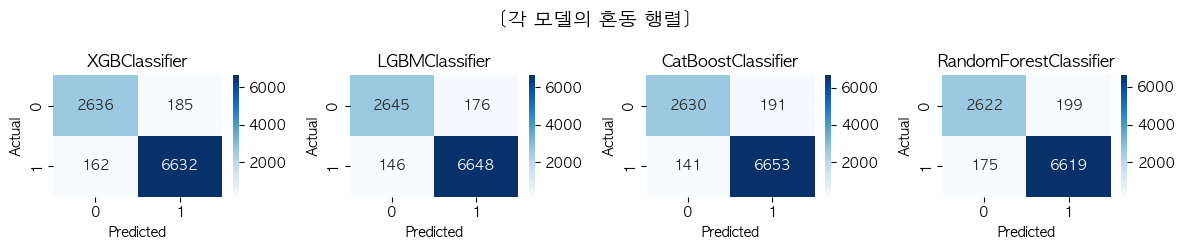

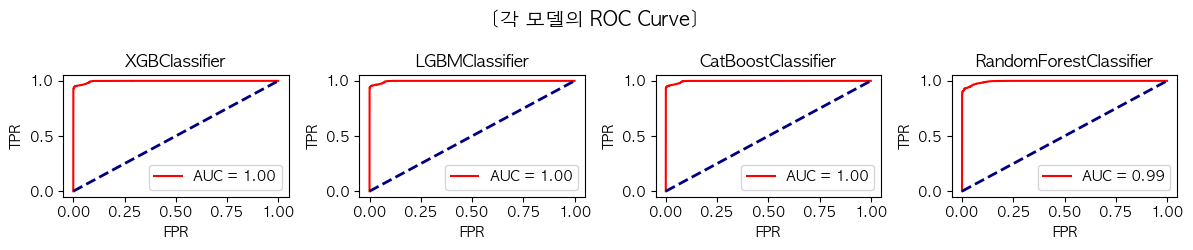

In [283]:
##  ML 모델별로 학습 및 예측 결과

# 학습 및 예측 모델 4가지 리스트 (XGBoost, LightGBM, CatBoost, RandomForest)
model = [xgb.XGBClassifier(),
        LGBMClassifier(),
        CatBoostClassifier(verbose=0),
        RandomForestClassifier()]

# 모델명 리스트 (출력시 모델명 텍스트로 사용)
model_list = []
for i in range(len(model)):
    model_list.append(type(model[i]).__name__)

# 캔버스 4개 만들기 (혼동행렬 / ROC Curve / Feat.Imp. 상위 10항목 / Feat.Imp. 전체 분포)
fig, axs = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))
fig2, axs2 = plt.subplots(1, len(model), figsize=(3*len(model), 2.5))

# 캔버스 4개의 title
fig.suptitle('[각 모델의 혼동 행렬]', fontsize=14)
fig2.suptitle('[각 모델의 ROC Curve]', fontsize=14)

# 4개 ML 모델 학습 후 정확도, 혼동행렬, ROC, Feature Importance 출력하기
for i in range(len(model)): # 모델 리스트 크기만큼 반복
    model[i].fit(x_train, y_train) # 모델 한개씩 불러와서 학습
    y_pred = model[i].predict(x_test) # 각 모델 예측값
    probs = model[i].predict_proba(x_test)[:, 1] # 각 모델 클래스 1의 예측 확률
    
    # 평가지표 계산
    accuracy = accuracy_score(y_test, y_pred) # 정확도
    precision = precision_score(y_test, y_pred) # 정밀도: 양성이라고 예측한것중 실제 양성의 비율
    recall = recall_score(y_test, y_pred) # 재현율(민감도): 실제 양성 중 양성으로 예측된 비율
    f1 = f1_score(y_test, y_pred) # f1: 2 * (정밀도*재현율)/(정밀도+재현율)
    auc_score = roc_auc_score(y_test, probs)  # AUC 계산 (ROC 곡선 아래의 면적)
    
    # 평가지표 출력
    print(f"{model_list[i]}:")
    print(f" - Accuracy: {round(accuracy*100,2)}%")
    print(f" - Precision: {round(precision*100,2)}%")
    print(f" - Recall: {round(recall*100,2)}%")
    print(f" - F1 Score: {round(f1*100,2)}%")
    print(f" - AUC: {round(auc_score*100,2)}%")

    # 각 모델의 혼동 행렬을 히트맵으로 그리기
    conf_mat = confusion_matrix(y_test, y_pred) # 혼동 행렬 만들기 (2,2)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axs[i])
    axs[i].set_title(model_list[i])
    axs[i].set_ylabel('Actual')
    axs[i].set_xlabel('Predicted')

    # 각 모델의 ROC Curve 그리기
    fpr, tpr, thresholds = roc_curve(y_test, probs) # fpr, tp, thresholds 값 할당
    axs2[i].plot(fpr, tpr, color='red', label=f'AUC = {auc_score:.2f}') # ROC Curve 그리기
    axs2[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs2[i].set_title(model_list[i])
    axs2[i].set_xlabel('FPR')
    axs2[i].set_ylabel('TPR')
    axs2[i].legend(loc="lower right")
    print("------------------------------")
        
fig.tight_layout(), fig2.tight_layout()
plt.show()

Logistic Regression metrics
 - Accuracy: 77.46%
 - Precision: 80.69%
 - Recall: 89.53%
 - F1 Score: 84.88%
 - AUC: 81.7%


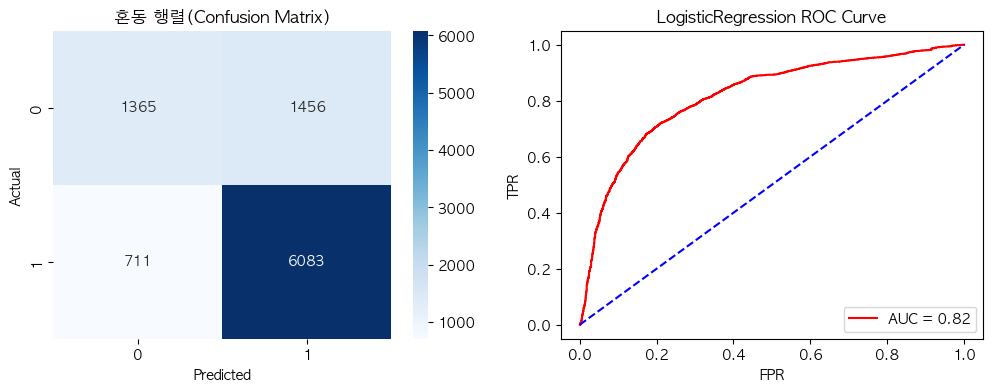

In [292]:
## logistic regression

# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression(max_iter=20000)  # 최대 반복 횟수를 설정
model.fit(x_train, y_train)
y_pred = model.predict(x_test) # test dataset 결과 예측
probs = model.predict_proba(x_test)[:, 1]  # 클래스 1에 대한 예측 확률

# 평가지표 계산
accuracy = accuracy_score(y_test, y_pred) # 정확도
precision = precision_score(y_test, y_pred) # 정밀도: 양성이라고 예측한것중 실제 양성의 비율
recall = recall_score(y_test, y_pred) # 재현율(민감도): 실제 양성 중 양성으로 예측된 비율
f1 = f1_score(y_test, y_pred) # f1: 2 * (정밀도*재현율)/(정밀도+재현율)
auc_score = roc_auc_score(y_test, probs)  # AUC 계산 (ROC 곡선 아래의 면적)

# 평가지표 출력
print(f"Logistic Regression metrics")
print(f" - Accuracy: {round(accuracy*100,2)}%")
print(f" - Precision: {round(precision*100,2)}%")
print(f" - Recall: {round(recall*100,2)}%")
print(f" - F1 Score: {round(f1*100,2)}%")
print(f" - AUC: {round(auc_score*100,2)}%")

fig, axs = plt.subplots(1, 2, figsize=(12,4))

# 혼동 행렬(Confusion Matrix)
confusion = confusion_matrix(y_test, y_pred)
# 히트맵으로 시각화
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[0])
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')
axs[0].set_title('혼동 행렬(Confusion Matrix)')

# ROC 그래프 그리기
fpr, tpr, thresholds = roc_curve(y_test, probs) #fpr, tpr, thresholds 값 변수에 할당
axs[1].plot(fpr, tpr, color='red', label=f'AUC = {auc_score:.2f}') # ROC Curve 그리기
axs[1].plot([0, 1], [0, 1], color='blue', linestyle='--')
axs[1].set_title('LogisticRegression ROC Curve')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].legend(loc="lower right")

plt.show()

Epoch 1/30
71/71 [==============================] - 1s 8ms/step - loss: 0.6702 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.8493 - val_sparse_categorical_accuracy: 0.6980
Epoch 2/30
71/71 [==============================] - 0s 4ms/step - loss: 0.5358 - sparse_categorical_accuracy: 0.7542 - val_loss: 1.2293 - val_sparse_categorical_accuracy: 0.6978
Epoch 3/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4903 - sparse_categorical_accuracy: 0.7753 - val_loss: 2.6201 - val_sparse_categorical_accuracy: 0.6953
Epoch 4/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4365 - sparse_categorical_accuracy: 0.7961 - val_loss: 5.4868 - val_sparse_categorical_accuracy: 0.6953
Epoch 5/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4026 - sparse_categorical_accuracy: 0.8061 - val_loss: 9.0204 - val_sparse_categorical_accuracy: 0.6951
Epoch 6/30
71/71 [==============================] - 0s 4ms/step - loss: 0.3678 - sparse_categorical_accuracy: 

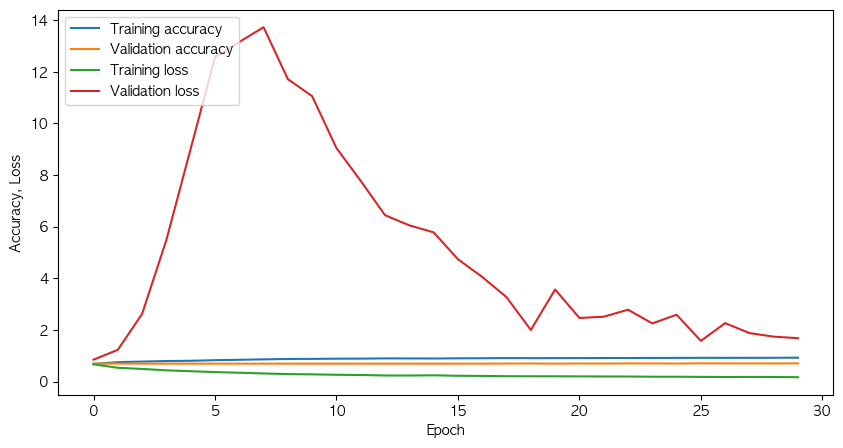

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               7168      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [285]:
# DNN 모델 학습

# 하이퍼파라미터 설정
epoch = 30 # 학습 반복 횟수
input_dim = 55
act = 'LeakyReLU' # 활성화 함수
opt = 'adam' # optimizer
batch = 256 # batch size
drops = 0.2

val_rate = 0.20 # 검증데이터 비율
# -> 이경우 마지막 20%가 검증 데이터로 사용됨 (비율을 고려하기 위해 미리 나눠야 함)
# x_train_exp, x_val_exp, y_train, y_val = train_test_split(x_train_exp, y_train, test_size=0.3, stratify=y_train)

# 모델 정의(구조)
def make_dnn_model():
    model = Sequential()
    model.add(Dense(128, activation=act, input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(drops))
    model.add(Dense(256, activation=act))
    model.add(BatchNormalization())
    model.add(Dropout(drops))
    model.add(Dense(128, activation=act))
    model.add(BatchNormalization())
    model.add(Dropout(drops))
    model.add(Dense(64, activation=act))
    model.add(BatchNormalization())
    model.add(Dropout(drops))
    model.add(Dense(2, activation='softmax'))
    
    return model

dnn_model = make_dnn_model() # 모델 초기화

# 모델 컴파일
dnn_model.compile(optimizer=opt, # optimizer: 학습 최적화 알고리즘
                loss='sparse_categorical_crossentropy', # 사용할 손실 함수
                metrics=['sparse_categorical_accuracy']) # 모델의 평가 지표

# monitor 지표를 기준으로 베스트 모델을 저장
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True,
                    monitor='val_sparse_categorical_accuracy', mode='max')
                    ]

history = dnn_model.fit(x_train, y_train, # 학습데이터, 라벨
                        batch_size=batch, # batch 크기 지정
                        validation_split=val_rate, # 검증용 데이터의 비율 지정 (마지막 부분이 할당됨)
                        epochs=epoch, # 학습 반복 횟수
                        callbacks=callbacks) # 검증 정확도가 올라갈때만 모델 저장

# 훈련/검증 정확도 최대값과 해당 인덱스를 변수에 할당
max_train_accuracy = max(history.history['sparse_categorical_accuracy'])
max_val_accuracy = max(history.history['val_sparse_categorical_accuracy'])
max_tra_acc_idx = np.argmax(history.history['sparse_categorical_accuracy']) + 1
max_val_acc_idx = np.argmax(history.history['val_sparse_categorical_accuracy']) + 1

# 훈련/검증 loss 최소값과 해당 인덱스를 변수에 할당
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
min_tra_loss_idx = np.argmin(history.history['loss']) + 1
min_val_loss_idx = np.argmin(history.history['val_loss']) + 1

# 훈련/검증 정확도 최대값과 해당 인덱스 출력, loss 최소값과 해당 인덱스 출력
print(f'Max train acc : {max_tra_acc_idx}_epoch_{max_train_accuracy}')
print(f'Max val acc: {max_val_acc_idx}_epoch_{max_val_accuracy}')
print(f'Min train loss : {min_tra_loss_idx}_epoch_{min_train_loss}')
print(f'Min val loss: {min_val_loss_idx}_epoch_{min_val_loss}')

#  베스트 모델로 test dataset 평가 (베스트 모델은 callbacks에 설정 됨)
model = load_model('best_model.h5')
loss_cnn, acc_cnn = model.evaluate(x_test, y_test)
print('test acc ', acc_cnn) # 정확도 출력
print('test loss ', loss_cnn) # loss 출력

# 클래스별 예측 확률, 예측 값
probs = model.predict(x_test)[:, 1] # 예측 결과가 클래스 1에 속할 확률
y_pred = np.argmax(model.predict(x_test), axis=1) # 예측 값

# 평가지표 계산
accuracy = accuracy_score(y_test, y_pred) # 정확도 (acc_cnn 과 동일함)
precision = precision_score(y_test, y_pred) # 정밀도: 양성이라고 예측한것중 실제 양성의 비율
recall = recall_score(y_test, y_pred) # 재현율(민감도): 실제 양성 중 양성으로 예측된 비율
f1 = f1_score(y_test, y_pred) # f1: 2 * (정밀도*재현율)/(정밀도+재현율)
auc_score = roc_auc_score(y_test, probs)  # AUC 계산 (ROC 곡선 아래의 면적)

# 평가지표 출력
print(f"CNN Metrics")
print(f" - Accuracy: {round(accuracy*100,2)}%")
print(f" - Precision: {round(precision*100,2)}%")
print(f" - Recall: {round(recall*100,2)}%")
print(f" - F1 Score: {round(f1*100,2)}%")
print(f" - AUC: {round(auc_score*100,2)}%")

## 학습데이터, 검증데이터의 정확도, loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Accuracy, Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 모델 구조 / 파라미터 개수 확인
model.summary()


 - threshold 1.0 -> Accuracy : 84.91%


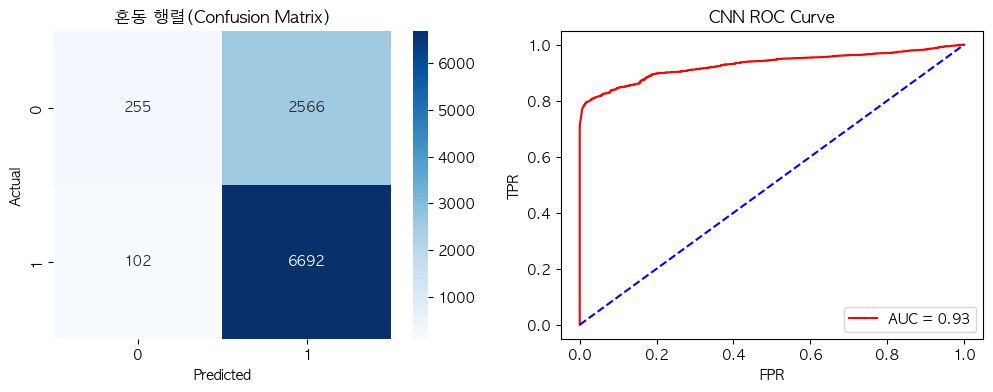

In [286]:
## 모델 혼동행렬과 ROC Curve 그리기
fig, axs = plt.subplots(1, 2, figsize=(12,4))

# 혼동 행렬(Confusion Matrix)
confusion = confusion_matrix(y_test, y_pred)
# 히트맵으로 시각화
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[0])
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')
axs[0].set_title('혼동 행렬(Confusion Matrix)')

# ROC 그래프 그리기
fpr, tpr, thresholds = roc_curve(y_test, probs) #fpr, tpr, thresholds 값 변수에 할당
axs[1].plot(fpr, tpr, color='red', label=f'AUC = {auc_score:.2f}') # ROC Curve 그리기
axs[1].plot([0, 1], [0, 1], color='blue', linestyle='--')
axs[1].set_title('CNN ROC Curve')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].legend(loc="lower right")

plt.show()

Epoch 1/30
141/141 [==============================] - 2s 7ms/step - loss: 0.5675 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.7884 - val_sparse_categorical_accuracy: 0.6951
Epoch 2/30
141/141 [==============================] - 1s 8ms/step - loss: 0.5199 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.5986 - val_sparse_categorical_accuracy: 0.7023
Epoch 3/30
141/141 [==============================] - 1s 9ms/step - loss: 0.5121 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.5619 - val_sparse_categorical_accuracy: 0.7089
Epoch 4/30
141/141 [==============================] - 1s 7ms/step - loss: 0.5014 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.6377 - val_sparse_categorical_accuracy: 0.6427
Epoch 5/30
141/141 [==============================] - 1s 9ms/step - loss: 0.4961 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.3608
Epoch 6/30
141/141 [==============================] - 1s 9ms/step - loss: 0.4837 - sparse_categorica

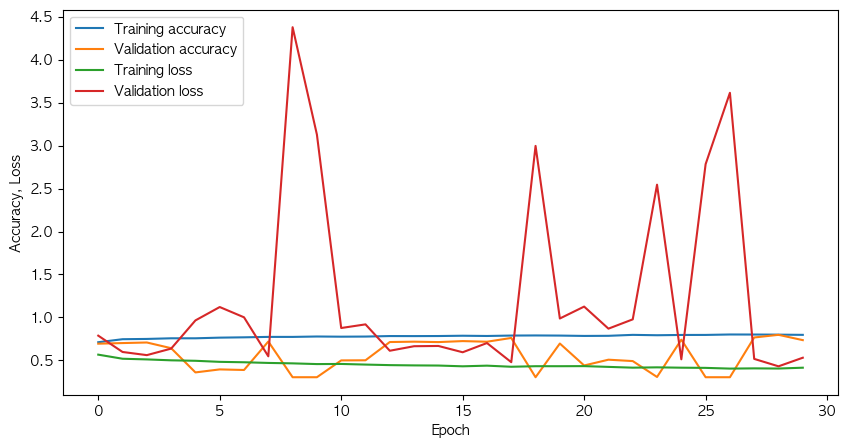

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 32)            128       
                                                                 
 batch_normalization_8 (Batc  (None, 55, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 32)            3104      
                                                                 
 batch_normalization_9 (Batc  (None, 55, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 32)            3104      
                                                                 
 batch_normalization_10 (Bat  (None, 55, 32)          

In [287]:

## CNN 학습 및 예측 결과

# CNN 학습을 위해 데이터 shape 변환
x_train_exp = np.expand_dims(x_train, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가
x_test_exp = np.expand_dims(x_test, -1) # x_test 배열의 마지막 차원에 새로운 축을 추가

# 하이퍼파라미터 설정
epoch = 30 # 학습 반복 횟수
input_dim = 55
act = 'LeakyReLU' # 활성화 함수
opt = 'adam' # optimizer
filter = 32 # Conv1D Layer의 filter수
batch = 128 # batch size
kernel = 3 # filter의 kernel size
drops = 0.2
val_rate = 0.20 # 검증데이터 비율
# -> 이경우 마지막 20%가 검증 데이터로 사용됨 (비율을 고려하기 위해 미리 나눠야 함)
# x_train_exp, x_val_exp, y_train, y_val = train_test_split(x_train_exp, y_train, test_size=0.3, stratify=y_train)


# 모델 정의(구조)

def make_cnn_model():
    model = Sequential()
    # Conv1D 1Layer
    model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act,
                    padding='same', input_shape=(55, 1)))
    model.add(BatchNormalization()) # batch 데이터의 분포를 정규화

    # Conv1D 2Layer
    model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act,
                    padding='same'))
    model.add(BatchNormalization()) # batch 데이터의 분포를 정규화

    # Conv1D 3Layer
    model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act,
                    padding='same'))
    model.add(BatchNormalization()) # batch 데이터의 분포를 정규화
    
    # GlobalAveragePooling1D Layer
    model.add(GlobalAveragePooling1D())
    # - 각 feature map의 평균을 계산하여 차원을 축소
    # - Flatten() 대신 사용하여 파라미터 수를 줄이고 과적합을 방지
    # model.add(Flatten())
    # model.add(Dropout(drops))

    # model.add(Dense(16, activation=act))
    # model.add(BatchNormalization())

    model.add(Dense(2, activation='softmax'))
    
    return model

cnn_model = make_cnn_model() # 모델 초기화

# 모델 컴파일
cnn_model.compile(optimizer=opt, # optimizer: 학습 최적화 알고리즘
                loss='sparse_categorical_crossentropy', # 사용할 손실 함수
                metrics=['sparse_categorical_accuracy']) # 모델의 평가 지표

# monitor 지표를 기준으로 베스트 모델을 저장
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True,
                    monitor='val_sparse_categorical_accuracy', mode='max')
                    ]

history = cnn_model.fit(x_train_exp, y_train, # 학습데이터, 라벨
                        batch_size=batch, # batch 크기 지정
                        validation_split=val_rate, # 검증용 데이터의 비율 지정 (마지막 부분이 할당됨)
                        # validation_data=(x_val_exp, y_val), # 검증 데이터 미리 나누기 -> 라벨의 비율 고려
                        epochs=epoch, # 학습 반복 횟수
                        callbacks=callbacks) # 검증 정확도가 올라갈때만 모델 저장

# 훈련/검증 정확도 최대값과 해당 인덱스를 변수에 할당
max_train_accuracy = max(history.history['sparse_categorical_accuracy'])
# sparse_categorical_crossentropy 하면 나는 원핫인코딩 처리를 안하지만 실제로 모델 안에서는 모델이 원핫인코딩을 대신 처리해준다
# 마지막 Dense층 노드수와, 라벨의 원핫인코딩 길이는 같아야 한다.
max_val_accuracy = max(history.history['val_sparse_categorical_accuracy'])
max_tra_acc_idx = np.argmax(history.history['sparse_categorical_accuracy']) + 1
max_val_acc_idx = np.argmax(history.history['val_sparse_categorical_accuracy']) + 1
# 훈련/검증 loss 최소값과 해당 인덱스를 변수에 할당
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss']) 
min_tra_loss_idx = np.argmin(history.history['loss']) + 1
min_val_loss_idx = np.argmin(history.history['val_loss']) + 1

# 훈련/검증 정확도 최대값과 해당 인덱스 출력, loss 최소값과 해당 인덱스 출력
print(f'Max train acc : {max_tra_acc_idx}_epoch_{max_train_accuracy}')
print(f'Max val acc: {max_val_acc_idx}_epoch_{max_val_accuracy}')
print(f'Min train loss : {min_tra_loss_idx}_epoch_{min_train_loss}')
print(f'Min val loss: {min_val_loss_idx}_epoch_{min_val_loss}')

#  베스트 모델로 test dataset 평가 (베스트 모델은 callbacks에 설정 됨)
model = load_model('best_model.h5')
loss_cnn, acc_cnn = model.evaluate(x_test_exp, y_test)
print('test acc ', acc_cnn) # 정확도 출력
print('test loss ', loss_cnn) # loss 출력

# 클래스별 예측 확률, 예측 값
probs = model.predict(x_test_exp)[:, 1] # 예측 결과가 클래스 1에 속할 확률
y_pred = np.argmax(model.predict(x_test_exp), axis=1) # 예측 값

# 평가지표 계산
accuracy = accuracy_score(y_test, y_pred) # 정확도 (acc_cnn 과 동일함)
precision = precision_score(y_test, y_pred) # 정밀도: 양성이라고 예측한것중 실제 양성의 비율
recall = recall_score(y_test, y_pred) # 재현율(민감도): 실제 양성 중 양성으로 예측된 비율
f1 = f1_score(y_test, y_pred) # f1: 2 * (정밀도*재현율)/(정밀도+재현율)
auc_score = roc_auc_score(y_test, probs)  # AUC 계산 (ROC 곡선 아래의 면적)

# 평가지표 출력
print(f"CNN Metrics")
print(f" - Accuracy: {round(accuracy*100,2)}%")
print(f" - Precision: {round(precision*100,2)}%")
print(f" - Recall: {round(recall*100,2)}%")
print(f" - F1 Score: {round(f1*100,2)}%")
print(f" - AUC: {round(auc_score*100,2)}%")

## 학습데이터, 검증데이터의 정확도, loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Accuracy, Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 모델 구조 / 파라미터 개수 확인
model.summary()


In [ ]:
# 데이터 스케일링 후 ML 학습

In [282]:
# 원본 + 요약으로 학습 99% 
# [학습 모델 : autoML]
#   - 미완료 데이터는 삭제하면 안됨(공정 조건이 유의미함) -> 시각화
#   - 전체 데이터 시각화 (스캐터, 히트맵)

# 요약 데이터 피쳐 제거 후 학습 97% (설비에서 얻어진 순수 데이터로만)
# [학습 모델 : autoML, 선형회귀, 4가지 ML, CNN, DL]
#   - 요약 데이터 피쳐와 타겟 클래스별로 구분 시각화
#     -> 얼마나 연관이 있는지 -> 차이는 있으나 결정적인 요인은 없다

# 데이터 스케일링 비교


#########
# 결론
# - 설비에서 얻어진 데이터로만 학습하면 97% 
# - 추가 데이터를 입력하면 99.9%
